In [1]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import torch
import math
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  
import numpy as np
import gc

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Data

csv: ”Frame Name”, ”Visibility Class”, ”X”, ”Y”, and ”Trajectory Pattern”

    ”Visibility Class”: V C = 0 implies the ball is not; V C = 1 implies the ball can be easily identified. V C = 2 implies the ball is in the frame but can not be easily identified. V C = 3 implies the ball is occluded by other objects
    
    ”X” and ”Y” indicate the coordinate of tennis in the pixel coordinate

    ”Trajectory Pattern” indicates the ball movement types and are classified into three categories: flying, hit, and bouncing.

### Data Preprocess

In [3]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
def preprocess_and_save(base_path, output_path, frame_info=3, resize_size=(360,640)):
    transform = transforms.Compose([
        transforms.Resize(resize_size),
        transforms.ToTensor()
    ])
    os.makedirs(output_path, exist_ok=True)
    for game_name in sorted(os.listdir(base_path)):
        game_path = os.path.join(base_path, game_name)
        if not os.path.isdir(game_path):
            continue
        for clip_name in sorted(os.listdir(game_path)):
            clip_path = os.path.join(game_path, clip_name)
            if not os.path.isdir(clip_path):
                continue
            label_path = os.path.join(clip_path, 'Label.csv')
            if not os.path.exists(label_path):
                continue
            label_df = pd.read_csv(label_path)
            image_names = label_df['file name'].tolist()
            if len(image_names) < frame_info:
                continue
            output_clip_path = os.path.join(output_path, game_name, clip_name)
            os.makedirs(output_clip_path, exist_ok=True)
            for idx in range(frame_info // 2, len(image_names) - frame_info // 2):
                imgs = []
                for i in range(idx - frame_info//2, idx + frame_info//2 + 1):
                    img_name = image_names[i]
                    img_path = os.path.join(clip_path, img_name)
                    img = Image.open(img_path).convert('RGB')
                    if i == idx:
                        orig_size = img.size  # (W, H)
                    img = transform(img)
                    img = (img * 255).to(torch.uint8)
                    imgs.append(img)
                visibility = label_df.iloc[idx]['visibility']
                x = label_df.iloc[idx]['x-coordinate']
                y = label_df.iloc[idx]['y-coordinate']
                orig_W, orig_H = orig_size
                if math.isnan(x) or math.isnan(y):
                    x_resized, y_resized = -1, -1
                else:
                    x_resized = x * (resize_size[1] / orig_W)
                    y_resized = y * (resize_size[0] / orig_H)
                target = torch.tensor([visibility, x_resized, y_resized], dtype=torch.float32)

                imgs = torch.cat(imgs, dim=0)  # (3*frame_info, H, W)
                save_data = {
                    'image': imgs,          # (3*frame_info, H, W)
                    'target': target,       # (visibility, x_resized, y_resized)
                    'orig_size': orig_size  # (W, H)
                }

                save_name = f"{idx:05d}.pt"
                save_path = os.path.join(output_clip_path, save_name)
                torch.save(save_data, save_path)
    print("Preprocessing done! All 3*frame_info-channel images saved!")

In [4]:
base_path = './Dataset'
preprocess_path = './Dataset_preprocess'
frame_info = 1
preprocess_and_save(base_path, preprocess_path, frame_info)

KeyboardInterrupt: 

In [ ]:
class PreprocessedTrackNetDataset(Dataset):
    def __init__(self, processed_base_path):
        super().__init__()
        self.data = []
        self.memory_cache = {}

        for game_name in sorted(os.listdir(processed_base_path)):
            game_path = os.path.join(processed_base_path, game_name)
            if not os.path.isdir(game_path):
                continue

            for clip_name in sorted(os.listdir(game_path)):
                clip_path = os.path.join(game_path, clip_name)
                if not os.path.isdir(clip_path):
                    continue

                for file_name in sorted(os.listdir(clip_path)):
                    if file_name.endswith('.pt'):
                        file_path = os.path.join(clip_path, file_name)
                        self.data.append(file_path)
                        self.memory_cache[file_path] = torch.load(file_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.memory_cache[self.data[idx]]
        img = data['image'].float() / 255.0    
        target = data['target'] 

        return img, target

In [ ]:
class PreloadTrackNetDataset(Dataset):
    def __init__(self, base_path, frame_info=3, resize_size=(360,640), transform=None):
        super().__init__()
        self.base_path = base_path
        self.new_H, self.new_W = resize_size
        self.frame_info = frame_info
        self.transform = transform or transforms.Compose([
            transforms.Resize((resize_size[0], resize_size[1])),
            transforms.ToTensor()
        ])

        self.data = []
        self.memory_cache = []
        for game_name in sorted(os.listdir(base_path)):
            game_path = os.path.join(base_path, game_name)
            if not os.path.isdir(game_path):
                continue

            for clip_name in sorted(os.listdir(game_path)):
                clip_path = os.path.join(game_path, clip_name)
                if not os.path.isdir(clip_path):
                    continue

                label_path = os.path.join(clip_path, 'Label.csv')
                if not os.path.exists(label_path):
                    continue

                label_df = pd.read_csv(label_path)
                image_names = label_df['file name'].tolist()

                if len(image_names) < frame_info:
                    continue

                for idx in range(self.frame_info // 2, len(image_names) - self.frame_info // 2):
                    imgs = []
                    orig_size = None

                    for i in range(idx - self.frame_info//2, idx + self.frame_info//2 + 1):
                        img_name = image_names[i]
                        img_path = os.path.join(clip_path, img_name)
                        img = Image.open(img_path).convert('RGB')
                        if i == idx:
                            orig_size = img.size  # (W, H)
                        img = self.transform(img)       
                        imgs.append(img)
                    imgs = torch.cat(imgs, dim=0)  
                    visibility = label_df.iloc[idx]['visibility']
                    x = label_df.iloc[idx]['x-coordinate']
                    y = label_df.iloc[idx]['y-coordinate']
                    orig_W, orig_H = orig_size
                    if math.isnan(x) or math.isnan(y):
                        x_resized, y_resized = -1, -1
                    else:
                        x_resized = x * (self.new_W / orig_W)
                        y_resized = y * (self.new_H / orig_H)
                    target = torch.tensor([visibility, x_resized, y_resized], dtype=torch.float32)
                    self.memory_cache.append((imgs, target))
        print(f"✅ Preloaded {len(self.memory_cache)} samples into RAM.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, target = self.memory_cache[idx]
        return img, target


### Data Loader

In [3]:
class TrackNetDataset(Dataset):
    def __init__(self, base_path, frame_info=3, resize_size=(360,640), transform=None):
        super().__init__()
        self.base_path = base_path
        self.new_H, self.new_W = resize_size
        self.frame_info = frame_info
        self.transform = transform or transforms.Compose([
            transforms.Resize((resize_size[0], resize_size[1])),
            transforms.ToTensor()
        ])

        self.data = []
        for game_name in sorted(os.listdir(base_path)):
            game_path = os.path.join(base_path, game_name)
            if not os.path.isdir(game_path):
                continue

            for clip_name in sorted(os.listdir(game_path)):
                clip_path = os.path.join(game_path, clip_name)
                if not os.path.isdir(clip_path):
                    continue

                label_path = os.path.join(clip_path, 'Label.csv')
                if not os.path.exists(label_path):
                    continue

                label_df = pd.read_csv(label_path)
                image_names = label_df['file name'].tolist()

                if len(image_names) < frame_info:
                    continue

                for idx in range(frame_info-1, len(image_names)):
                    self.data.append({
                        'clip_path': clip_path,
                        'label_df': label_df,
                        'center_idx': idx,
                    })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        clip_path = entry['clip_path']
        label_df = entry['label_df']
        center_idx = entry['center_idx']
        imgs = []
        for i in range(center_idx - self.frame_info + 1, center_idx + 1):
            img_name = label_df.iloc[i]['file name']
            img_path = os.path.join(clip_path, img_name)
            img = Image.open(img_path).convert('RGB')
            if i == center_idx:
                orig_W, orig_H = img.size
            if self.transform: 
                img = self.transform(img)
            imgs.append(img)
           
        imgs = torch.cat(imgs, dim=0)  
        visibility = label_df.iloc[center_idx]['visibility']
        x = label_df.iloc[center_idx]['x-coordinate']
        y = label_df.iloc[center_idx]['y-coordinate']
        if math.isnan(x) or math.isnan(y):
            x_resized, y_resized = -1, -1
        else:
            x_resized = x * (self.new_W / orig_W)
            y_resized = y * (self.new_H / orig_H)

        target = torch.tensor([visibility, x_resized, y_resized], dtype=torch.float32)

        return imgs, target


In [5]:
batch_size = 16
#resize_size=(360,640)
resize_size=(128,256)
preprocess_path = './Dataset_preprocess'
base_path = './Dataset'
frame_info = 3

In [7]:
full_dataset = TrackNetDataset(base_path, resize_size=resize_size)
full_loader = torch.utils.data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

In [8]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

#### Data Check

Images batch shape: torch.Size([16, 9, 128, 256])
Targets batch shape: torch.Size([16, 3])
tensor([[  2.0000, 185.2000,  85.8667],
        [  1.0000,  93.6000,  37.5111],
        [  1.0000, 119.6000,  51.3778],
        [  1.0000, 137.2000,  28.8000],
        [  1.0000,  94.6000,  48.0000],
        [  1.0000, 151.4000,  46.0444],
        [  1.0000, 100.6000,  20.2667],
        [  1.0000, 128.6000,  27.7333],
        [  1.0000, 108.0000,  43.9111],
        [  1.0000, 123.2000,  27.0222],
        [  1.0000,  71.6000,  92.0889],
        [  1.0000,  95.4000,  31.1111],
        [  1.0000, 132.4000,  35.5556],
        [  0.0000,  -1.0000,  -1.0000],
        [  1.0000, 117.6000,  34.4889],
        [  1.0000,  82.2000,  15.2889]])


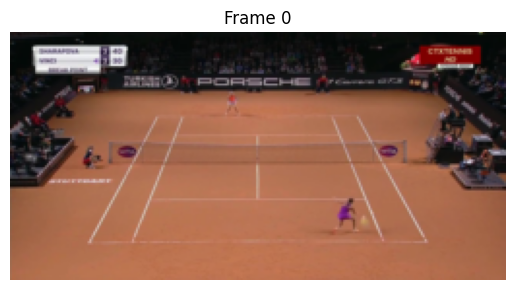

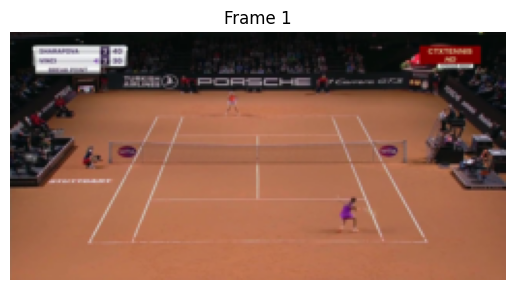

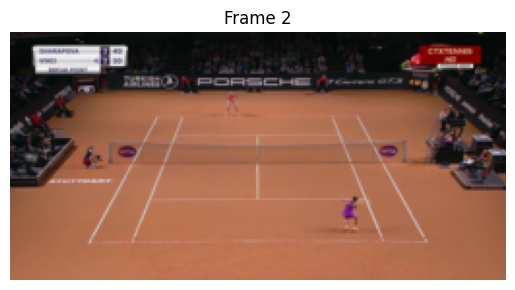

In [9]:
def show_frame(frame, title=''):
    frame = frame.permute(1, 2, 0).numpy()  # (C,H,W) → (H,W,C)
    plt.imshow(frame)
    plt.title(title)
    plt.axis('off')
    plt.show()
for (images, targets) in train_loader:
    print(f'Images batch shape: {images.shape}')
    print(f'Targets batch shape: {targets.shape}')
    break  
print(targets)
sample = images[0,:,:,:] 
target = targets[0]

for i in range(frame_info):
    frame = sample[i*3:(i+1)*3,:,:]
    show_frame(frame, f"Frame {i}")

## Model

In [16]:
import torch.nn as nn
import torch

class eca_layer(nn.Module):
    def __init__(self, channel, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.k_size = k_size
        self.conv = nn.Conv1d(channel, channel, kernel_size=k_size, bias=False, groups=channel)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = nn.functional.unfold(y.transpose(-1, -3), kernel_size=(1, self.k_size), padding=(0, (self.k_size - 1) // 2))
        y = self.conv(y.transpose(-1, -2)).unsqueeze(-1)
        y = self.sigmoid(y)
        x = x * y.expand_as(x)
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pad=1, stride=1, bias=True, use_eca=False):
        super().__init__()
        self.use_eca = use_eca
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=pad, bias=bias),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)
        )
        self.eca_layer = eca_layer(out_channels) if use_eca else None

    def forward(self, x):
        x = self.block(x)
        if self.use_eca:
            x = self.eca_layer(x)
        return x

class BallTrackerNet(nn.Module):
    def __init__(self, frame_info=3, out_channels=256, use_eca=False):
        super().__init__()
        self.out_channels = out_channels
        # VGG16:generate the feature map
        self.VGG16 = nn.Sequential(
            ConvBlock(in_channels=frame_info*3, out_channels=64, use_eca=use_eca),
            ConvBlock(in_channels=64, out_channels=64, use_eca=use_eca),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=64, out_channels=128, use_eca=use_eca),
            ConvBlock(in_channels=128, out_channels=128, use_eca=use_eca),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=128, out_channels=256, use_eca=use_eca),
            ConvBlock(in_channels=256, out_channels=256, use_eca=use_eca),
            ConvBlock(in_channels=256, out_channels=256, use_eca=use_eca),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=256, out_channels=512, use_eca=use_eca),
            ConvBlock(in_channels=512, out_channels=512, use_eca=use_eca),
            ConvBlock(in_channels=512, out_channels=512, use_eca=use_eca)
        )
            # DeconvNet
        self.deconvnet = nn.Sequential(
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=512, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=256, out_channels=128),
            ConvBlock(in_channels=128, out_channels=128),
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=128, out_channels=64),
            ConvBlock(in_channels=64, out_channels=64),
            ConvBlock(in_channels=64, out_channels=self.out_channels)
        )
        self._init_weights()
                  
    def forward(self, x): 
        batch_size = x.size(0)
        x = self.VGG16(x)
        x = self.deconvnet(x)
        out = x
        return out                       
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.uniform_(module.weight, -0.05, 0.05)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)  

In [20]:
def generate_heatmap(targets, H=360, W=640, sigma2=10):
    """
    targets: (batch_size, 3) -> (visibility, x, y)
    H, W: heatmap
    sigma: 
    """
    batch_size = targets.shape[0]
    heatmaps = torch.zeros((batch_size, 1, H, W), device=targets.device)
    for i in range(batch_size):
        visibility, x, y = targets[i]
        if visibility != 0:
            yy, xx = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
            xx = xx.float()
            yy = yy.float()
            center_x = x.clone().detach()
            center_y = y.clone().detach()
            heatmap = torch.exp(-((xx - center_x)**2 + (yy - center_y)**2) / (2 * sigma2))
            heatmap = heatmap / heatmap.max()  # normalize
            heatmap = heatmap.clone().detach()
            heatmaps[i, 0] = heatmap

    label = (heatmaps*255).long()
    return label

## Train and Evaluate

In [17]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    scaler = torch.GradScaler("cuda")
    running_loss = 0.0
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    running_loss = 0.0
    for iter_id, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        with torch.autocast("cuda"):
            outputs = model(images)
            gt = generate_heatmap(targets, H=resize_size[0], W=resize_size[1]).squeeze(1)
            loss = criterion(outputs, gt)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        batch_bar.set_postfix(
        loss="{:.04f}".format(running_loss/(iter_id+1)),
        lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()
    running_loss /= len(train_loader)
    batch_bar.close()
    return running_loss

In [12]:
import torch.nn.functional as F
import cv2
from scipy.spatial import distance
def postprocess_heatmap(heatmap, scale=1):
    """from heatmap using HoughCircles collect (x,y)"""
    heatmap = heatmap * 255
    heatmap = heatmap.astype(np.uint8)
    _, binary = cv2.threshold(heatmap, 127, 255, cv2.THRESH_BINARY)
    circles = cv2.HoughCircles(binary, cv2.HOUGH_GRADIENT, dp=1, minDist=1,
                               param1=50, param2=2, minRadius=2, maxRadius=7)
    if circles is not None and len(circles[0]) == 1:
        x = int(circles[0][0][0] * scale)
        y = int(circles[0][0][1] * scale)
        return x, y
    return None, None

def validate(model, val_loader, criterion, min_dist=5):
    model.eval()
    losses = []
    total_dist = 0.0
    tp = 0.0
    fp = 0.0
    tn = 0.0
    fn = 0.0
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Validation')
    with torch.no_grad():
        for iter_id, (images, targets) in enumerate(val_loader):
            images = images.to(device)          # (B, 9, H, W)
            targets = targets.to(device)
            gt = generate_heatmap(targets,H=resize_size[0], W=resize_size[1]).squeeze(1)
            x_gt_batch = targets[:,1]  # (B,)
            y_gt_batch = targets[:, 2]  # (B,)
            vis_batch = targets[:, 0]   # (B,)

            outputs = model(images)                         # (B, 256, H, W)
            loss = criterion(outputs, gt)
            losses.append(loss.item())

            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)  # (B, H, W)
            B, H, W = preds.shape
            pred_classes_flat = preds.view(B, -1) # (B, HxW)
            max_indices = torch.argmax(pred_classes_flat, dim=1)  # (B,)
            y_pred = max_indices // W
            x_pred = max_indices % W
            # L2 distance between predicted and GT coordinates
            dist = torch.sqrt((x_pred.float() - x_gt_batch) ** 2 + (y_pred.float() - y_gt_batch) ** 2)

            # Logical mask
            pred_exists = (pred_classes_flat.max(dim=1).values > 0) 
            gt_exists = (vis_batch != 0)
            tp_mask = pred_exists & gt_exists & (dist < min_dist)
            fp_mask = pred_exists & (~gt_exists | (dist >= min_dist))
            fn_mask = (~pred_exists) & gt_exists
            tn_mask = (~pred_exists) & (~gt_exists)

            tp += tp_mask.sum().item()
            fp += fp_mask.sum().item()
            fn += fn_mask.sum().item()
            tn += tn_mask.sum().item()
            total_dist += torch.sum(dist)/B
            batch_bar.set_postfix(loss="{:.04f}".format(np.mean(losses)),
                                  dist="{:.04f}".format((total_dist/(iter_id+1)).item()),
                                  tp=tp, 
                                  tn=tn, 
                                  fp=fp, 
                                  fn=fn)
            batch_bar.update()
    eps = 1e-15
    total = tp + fp + fn + tn
    avg_loss = np.sum(losses) / total
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)

    batch_bar.close()
    return np.mean(losses), total_dist/len(val_loader), precision, recall, f1

## Experiments

In [13]:
epoch_num = 100
best_lev_dist = 1500

In [14]:
gc.collect()
torch.cuda.empty_cache()

In [18]:
model = BallTrackerNet(use_eca=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.95, patience=1, verbose=True, threshold=1e-2)

c:\Users\karby\anaconda3\envs\ml_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
for epoch in range(0, epoch_num):
    print("\nEpoch: {}/{}".format(epoch+1, epoch_num))
    # Call train and validate 
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_dist, precision, recall, f1 = validate(model, val_loader, criterion)
    scheduler.step(val_dist)
    print("\nEpoch {}/{}: \t Train Loss {:.04f} ".format(
          epoch + 1,
          epoch_num,
          train_loss
          ))
    print("Val loss {:.04f} \t Val dist {:.04f} \t precision: {:.04f} \t recall: {:.04f}\t f1: {:.04f}".format(
          val_loss, val_dist, precision, recall, f1
          ))
    torch.cuda.empty_cache()
    if val_dist <= best_lev_dist:
        best_lev_dist = val_dist
        # Save your model checkpoint here
        print("Saving model")
        torch.save(model.state_dict(), 'model_best_eca.pth')
        # Saving the model and optimizer states
      #   torch.save({
      #         'model_state_dict': model.state_dict(),
      #         'optimizer_state_dict': optimizer.state_dict(),
      #         'scheduler_state_dict':scheduler.state_dict(),
      #         'val_dist': val_dist, 
      #          'epoch': epoch
      #         }, "Model")


Epoch: 1/100



Epoch 1/100: 	 Train Loss 1.0396 
Val loss 0.1231 	 Val dist 132.7571 	 precision: 0.0000 	 recall: 0.0000	 f1: 0.0000
Saving model

Epoch: 2/100



Epoch 2/100: 	 Train Loss 0.1040 
Val loss 0.0925 	 Val dist 130.9304 	 precision: 0.0877 	 recall: 0.0013	 f1: 0.0026
Saving model

Epoch: 3/100


Train:  84%|████████▍ | 826/983 [07:24<01:15,  2.08it/s, loss=0.0606, lr=0.0100]

### Test

In [ ]:
import cv2
import torch
import numpy as np
from torchvision import transforms

def preprocess_frame(frame, resize_size=(360, 640)):
    frame = cv2.resize(frame, resize_size)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    tensor = transforms.ToTensor()(frame_rgb)  # (3, H, W)
    return tensor

def predict_xy(model, frame1, frame2, frame3, device='cuda'):
    input_tensor = torch.cat([frame1, frame2, frame3], dim=0).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(input_tensor)  # (1, 256, H, W)
        pred = torch.argmax(out, dim=1).squeeze(0)
        max_idx = torch.argmax(pred.view(-1))
        h, w = pred.shape
        y = max_idx // w
        x = max_idx % w
    return int(x.item()), int(y.item())

def process_video(input_video_path, output_video_path, model, resize_size=(360, 640), device='cuda'):
    cap = cv2.VideoCapture(input_video_path)
    width, height = resize_size[1], resize_size[0]

    # Prepare video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_video = cv2.VideoWriter(output_video_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (width, height))

    # Buffer for sliding window
    buffer = []

    model.eval()
    with torch.no_grad():
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            buffer.append(preprocess_frame(frame, resize_size))
            if len(buffer) < 3:
                continue
            if len(buffer) > 3:
                buffer.pop(0)

            f1, f2, f3 = buffer
            x, y = predict_xy(model, f1, f2, f3, device)
 
            # Mark center frame
            img = f2.permute(1, 2, 0).cpu().numpy()
            img = (img * 255).astype(np.uint8)
            img = cv2.circle(img.copy(), (x, y), 5, (0, 0, 255), -1)  # 红点

            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            out_video.write(img_bgr)

    cap.release()
    out_video.release()
    print(f"✅  {output_video_path}")


In [ ]:
def preprocess_image(path, resize_size=(360, 640)):
    img = cv2.imread(path)
    img = cv2.resize(img, resize_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = transforms.ToTensor()(img)  # (3, H, W)
    return img

def get_model_input(frame_info, paths):
    f = []
    for i in range(frame_info):
        f.append(preprocess_image(paths[i]))
    input_tensor = torch.cat(f, dim=0).unsqueeze(0)  # shape: (1, 9, H, W)
    return input_tensor, f[-1] 

def predict_ball_position(model, input_tensor, device='cuda'):
    model.eval()
    input_tensor = input_tensor.to(device)
    with torch.no_grad():
        out = model(input_tensor)  # (1, 256, H, W)
        pred = torch.argmax(out, dim=1).squeeze(0)  # (H, W)
        max_idx = torch.argmax(pred.view(-1))
        h, w = pred.shape
        y = max_idx // w
        x = max_idx % w
    return int(x.item()), int(y.item())

def draw_and_save(image_tensor, x, y, save_path=None):
    image = image_tensor.permute(1, 2, 0).numpy()  # (H, W, C)
    image = (image * 255).astype(np.uint8)
    image = cv2.circle(image.copy(), (x, y), 5, (255, 0, 0), -1)  # 红点

    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    else:
        plt.imshow(image)
        plt.title(f"Predicted Ball Position: ({x}, {y})")
        plt.axis('off')
        plt.show()

In [ ]:
def generate_plot(model, images):
    # image # (1, 256, H, W)
    model.eval()
   
    outputs = model(images)                         # (1, 256, H, W)

    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)  # (1, H, W)
    B, H, W = preds.shape
    pred_classes_flat = preds.view(B, -1) # (B, HxW)
    max_indices = torch.argmax(pred_classes_flat, dim=1)  # (B,)
    y_pred = max_indices // W
    x_pred = max_indices % W
    x, y = int(x), int(y)
    img_marked = cv2.circle(img.copy(), (x, y), radius=5, color=(0, 0, 255), thickness=-1) 

    return 

In [ ]:
import cv2
import os

def extract_frames(video_path, output_dir, target_fps=30):
    os.makedirs(output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Cannot open video")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    if original_fps == 0:
        print("Cannot get orginal fps")
        return

    frame_interval = int(round(original_fps / target_fps))
    if frame_interval == 0:
        frame_interval = 1

    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            filename = os.path.join(output_dir, f"frame_{saved_count:05d}.jpg")
            cv2.imwrite(filename, frame)
            saved_count += 1

        frame_count += 1

    cap.release()
    print(f"Saved,{saved_count}fps.")
